# Women in STEM workforce: predict income and prime job activity

### What is in this notebook?

We have looked at the gender pay gap over the years in the STEM workforce in the EDA notebook. The analysis also shows how the gender gap compare to one another in the various fields in STEM areas. In this notebook, I take a look at the machine learning models to predict the income and prime job activity with given other aspects of the data. It would answer the question of what kind of pay and what types of job would a STEMer expect to have in the work force.

# Importing and Tidying the Data

In [1]:
# import stuff
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context("talk")
%matplotlib inline

In [3]:
#import the data from csv file with a series of NAN values 
df1 = pd.read_csv('./../data/highered_00004.csv', dtype={'REFID': str},na_values=[96, 99, 98, 9996, 9998 ,
    9999, 999996, 999998, 999999, 9999998, 9999999] )
df1 = df1.drop(['REFID'], axis=1)
df2 = pd.read_csv('./../data/highered_00007.csv', dtype={'REFID': str},na_values=[96, 99, 98, 9996, 9998 ,
    9999, 999996, 999998, 999999, 9999998, 9999999] )
df3 = pd.read_csv('./../data/highered_00008.csv', dtype={'REFID': str},na_values=[96, 99, 98, 9996, 9998 ,
    9999, 999996, 999998, 999999, 9999998, 9999999] )
dfm = df1.merge(df2,  on=['PERSONID', 'YEAR', 'WEIGHT', 'SAMPLE', 'SURID'])

In [56]:
# explanation of the survey https://highered.ipums.org/highered/survey_designs.shtml

# Respondents from each of these three surveys with science or engineering degrees                               ##
# or occupations are compiled into one dataset: the SESTAT (the Scientists and Engineers Statistical Data System)##
df = dfm.merge(df3, on=['PERSONID', 'YEAR', 'SURID'])


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478747 entries, 0 to 478746
Data columns (total 49 columns):
PERSONID    478747 non-null int64
YEAR        478747 non-null int64
WEIGHT      478737 non-null float64
SAMPLE      478747 non-null int64
SURID       478747 non-null int64
AGE         478747 non-null int64
BIRYR       478747 non-null int64
GENDER      478747 non-null int64
MINRTY      478747 non-null int64
RACETH      478747 non-null int64
BTHUS       478747 non-null int64
CTZUSIN     478747 non-null int64
CTZUS       438777 non-null float64
FNVS        20573 non-null float64
CHTOT       219740 non-null float64
BA03Y5      465491 non-null float64
NBAMED      463945 non-null float64
NBAMEMG     465494 non-null float64
DGRDG       478747 non-null int64
HD03Y5      478747 non-null int64
NDGMED      478747 non-null int64
NDGMEMG     478747 non-null int64
LFSTAT      478747 non-null int64
WRKG        478747 non-null int64
HRSWKGR     407478 non-null float64
WKSWKGR     407478 non-n

In [62]:
df['WEIGHT'].describe()

count    478737.000000
mean        245.054037
std         427.175429
min           0.369800
25%          29.140400
50%         106.883500
75%         286.252200
max       14782.721400
Name: WEIGHT, dtype: float64

In [5]:
df_employed = df[df['LFSTAT']==1]
df_employed_small = df_employed.drop(['CTZUS', 'WEIGHT', 'WRKG', 'NRREA','FNVS', 'CHTOT', 'CPI2009C', 'PERSONID', 'LFSTAT','BA03Y5', 'LOOKWK'], axis=1)
#df_employed_small.info()

In [6]:
#df_employed_l = df_employed_small[df_employed_small.SALARY != 150000]
#df_employed_l = df_employed_small[df_employed_small['NDGMEMG']==3].dropna()
df_employed_l = df_employed_small.dropna()

## Correlations Overviews
Next we use pandas' correlation funcion and seaborns heatmap to get a general idea of how the features are related to each other.

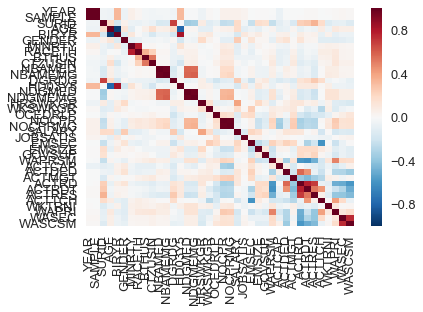

In [7]:
sns.heatmap(df_employed_l.corr())

In [8]:
df_employed_l.corr()['SALARY']

YEAR        0.047753
SAMPLE      0.049694
SURID       0.193761
AGE         0.186057
BIRYR      -0.162161
GENDER      0.257586
MINRTY     -0.102562
RACETH     -0.101382
BTHUS      -0.055799
CTZUSIN     0.012500
NBAMED     -0.037537
NBAMEMG    -0.034085
DGRDG       0.263496
HD03Y5     -0.167808
NDGMED     -0.010046
NDGMEMG    -0.001453
HRSWKGR     0.403946
WKSWKGR     0.176768
OCEDRLP    -0.128177
NOCPR      -0.091245
NOCPRMG    -0.056801
SALARY      1.000000
JOBSATIS   -0.140447
EMSEC       0.215927
EMSIZE      0.169909
GOVSUP      0.022820
WAPRSM     -0.034008
ACTCAP      0.042460
ACTDED      0.126313
ACTMGT      0.119822
ACTRD       0.115217
ACTRDT     -0.012041
ACTRES      0.036424
ACTTCH     -0.183005
WKTRNI      0.007476
WAPRI      -0.172204
WASEC      -0.133979
WASCSM     -0.141206
Name: SALARY, dtype: float64

## Dummy the categorical columns
Looks like many of the columns are catagorical and has been stored in the same column as numbers, such as the field of major, highest degree and etc. They need to be treated that way. Here pandas get_dummies are used for this purpose. 

In [9]:
df_employed_d = pd.get_dummies(df_employed_l, columns=['RACETH','NBAMED', 'NBAMEMG', 'NDGMED', 'EMSEC','EMSIZE', 'GOVSUP', 'NDGMEMG', 'OCEDRLP', 'WAPRSM', 'WAPRI', 'WKTRNI', 'WASEC', 'NOCPR','WASCSM', 'NOCPRMG', 'SAMPLE', 'HD03Y5', 'DGRDG', 'JOBSATIS','SURID','HRSWKGR','WKSWKGR'], drop_first=True)

In [10]:
X = df_employed_d[df_employed_d['YEAR']==2013].drop(['SALARY'], axis=1)
y = df_employed_d[df_employed_d['YEAR']==2013]['SALARY']

#import the machine learning algorithm packages
# Import modules of linear regresssion, evaluation, and train test split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
# Import Lasso
from sklearn.linear_model import Lasso
# Import Ridge
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Create the regressor: reg
reg = Ridge()


# Fit the model to the data
reg.fit(X_train,y_train)

# Compute predictions over the prediction space: y_pred
y_pred = reg.predict(X_test)

# Print R^2 
print(reg.score(X_test, y_test))

rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))


0.558807434679
Root Mean Squared Error: 27269.00915709602


Only looking at the data where salary is not 0. The R2 improved slightly. 

In [11]:
df_employed_no = df_employed_d[(df_employed_d['SALARY']>0)]
X = df_employed_no[df_employed_no['YEAR']==2013].drop(['SALARY'], axis=1)
y = df_employed_no[df_employed_no['YEAR']==2013]['SALARY']

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=41)

# Create the regressor: reg
reg = Ridge()


# Fit the model to the data
reg.fit(X_train,y_train)

# Compute predictions over the prediction space: y_pred
y_pred = reg.predict(X_test)

from copy import deepcopy as copy
# Cap the predicted value at 150000 as in the original data set 
y_pred = np.clip(y_pred, 0, 150000)
y_pred_base = copy( y_pred )


# Print R^2 
print(reg.score(X_test, y_test))

rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))

scores = cross_val_score(reg, X_train, y_train, cv=5)
print('cross validation scores:', scores)

0.574223238079
Root Mean Squared Error: 26461.216783331813
cross validation scores: [ 0.58108617  0.56424951  0.56566613  0.56120708  0.56811548]


#### The ridge and simple linear regression both give the determination coefficient ($R^2$) result of 0.51. It is not bad considering some essential fact contributing to the salary is unknown: level of the position, location of the job,  and company pay ability. This next cell shows a histogram of the actual salaries and the predicted salaries. We see the distribution of predected salary is more centrally located around the mean. Can this give us a hint as to what to do next?

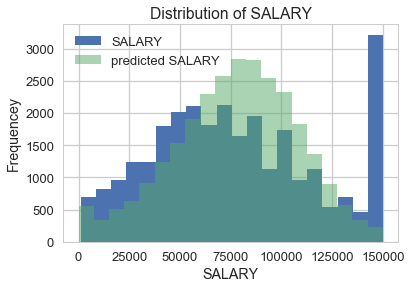

In [12]:
plt.hist(y_test, bins=20, label='SALARY')
plt.hist(y_pred,  bins=20, alpha=0.5, label='predicted SALARY')
plt.title("Distribution of SALARY")
plt.legend()
plt.xlabel("SALARY")
plt.ylabel("Frequencey")
plt.show()

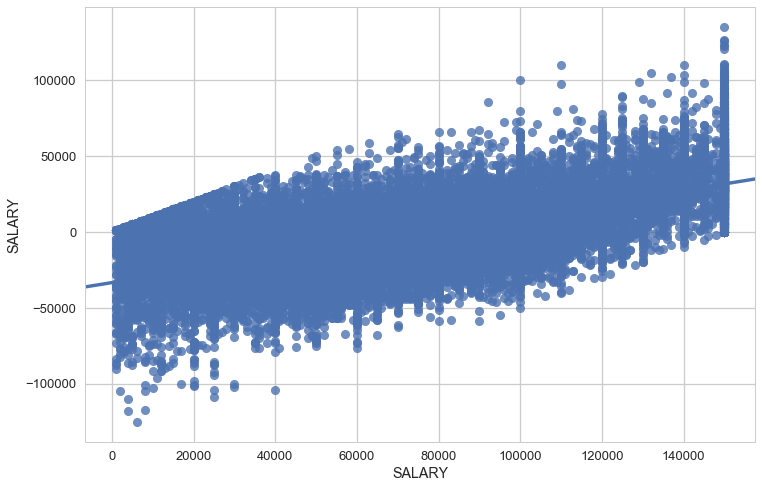

In [13]:
#### GREG ADDED - DELETE LATER ###

fig, ax = plt.subplots( figsize=( 12,8))
sns.regplot( y_test, y_test - y_pred)

In [14]:
## Use statsmodel simple ordinary least squares model to fit and predict our data

df_employed_no = df_employed_d[(df_employed_d['SALARY']>0)]
X = df_employed_no[df_employed_no['YEAR']==2013].drop(['SALARY'], axis=1)
y = df_employed_no[df_employed_no['YEAR']==2013]['SALARY']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Import regression modules
import statsmodels.api as sm
from statsmodels.formula.api import ols

mod = sm.OLS(y_train, X_train)
res = mod.fit()
y_pred_base = res.predict(X_test)
y_pred_base = np.clip(y_pred_base, 0, 150000)
print(res.summary() )


/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


                            OLS Regression Results                            
Dep. Variable:                 SALARY   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     632.6
Date:                Wed, 02 May 2018   Prob (F-statistic):               0.00
Time:                        20:15:29   Log-Likelihood:            -7.6556e+05
No. Observations:               65963   AIC:                         1.531e+06
Df Residuals:                   65822   BIC:                         1.533e+06
Df Model:                         140                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
YEAR               32.1568     74.193     

/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [15]:
## Feature selection by removing the statistically insignificant columns (p_value>0.001), use the statsmodel to fit again

feature_p = pd.DataFrame(res.pvalues, columns=['Pvalue'])
feature_select = feature_p[feature_p['Pvalue']<=0.001]
ls = feature_select.index.tolist()

df_employed_no = df_employed_d[(df_employed_d['SALARY']>0)]

X = df_employed_no[df_employed_no['YEAR']==2013][ls]
y = df_employed_no[df_employed_no['YEAR']==2013]['SALARY']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)


mod2 = sm.OLS(y_train, X_train)
res2 = mod2.fit()
print(res2.summary() )


                            OLS Regression Results                            
Dep. Variable:                 SALARY   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     915.6
Date:                Wed, 02 May 2018   Prob (F-statistic):               0.00
Time:                        20:15:31   Log-Likelihood:            -7.6572e+05
No. Observations:               65963   AIC:                         1.532e+06
Df Residuals:                   65866   BIC:                         1.533e+06
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
GENDER           6042.1524    237.852     

In [16]:
## Repeat the same feature selection process, run fit predict again. The R-squared increased?????

feature_p = pd.DataFrame(res2.pvalues, columns=['Pvalue'])
feature_select = feature_p[feature_p['Pvalue']<=0.001]
ls = []
ls = feature_select.index.tolist()

df_employed_no = df_employed_d[(df_employed_d['SALARY']>0)]

X = df_employed_no[df_employed_no['YEAR']==2013][ls]
y = df_employed_no[df_employed_no['YEAR']==2013]['SALARY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

mod3 = sm.OLS(y_train, X_train)
res3 = mod3.fit()
y_pred = res3.predict(X_test)
y_pred = np.clip(y_pred, 0, 150000)
print(res3.summary())

                            OLS Regression Results                            
Dep. Variable:                 SALARY   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     9419.
Date:                Wed, 02 May 2018   Prob (F-statistic):               0.00
Time:                        20:15:32   Log-Likelihood:            -7.6653e+05
No. Observations:               65963   AIC:                         1.533e+06
Df Residuals:                   65896   BIC:                         1.534e+06
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
GENDER           6455.0016    225.444     

In [17]:
#Test the data on the LinearRegression of sklearn: give different R2 score.
# Create the regressor: reg
reg = LinearRegression()

# Fit the model to the data
reg.fit(X_train,y_train)

# Compute predictions over the prediction space: y_pred
y_pred = reg.predict(X_test)

# Cap the predicted value at 150000 as in the original data set 
y_pred = np.clip(y_pred, 0, 150000)


# Print R^2 
print('training score:', reg.score(X_train, y_train))
print('testing score:', reg.score(X_test, y_test))

rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))

scores = cross_val_score(reg, X_train, y_train, cv=5)
print('cross validation scores:', scores)

training score: 0.561376165013
testing score: 0.552899932582
Root Mean Squared Error: 27091.22342027797
cross validation scores: [ 0.55795497  0.56066835  0.55184132  0.56552788  0.56461522]


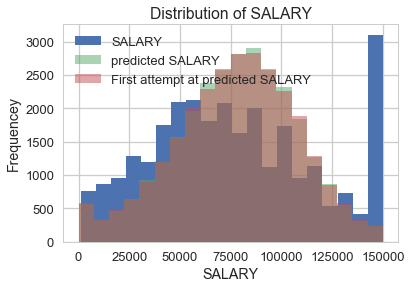

In [18]:
## Plot the distribution of salary, the first attempt predicted salary (cell 14) and the next 


plt.hist(y_test, bins=20, label='SALARY')
plt.hist(y_pred,  bins=20, alpha=0.5, label='predicted SALARY')
plt.hist(y_pred_base, bins=20, alpha=0.5, label='First attempt at predicted SALARY')
plt.title("Distribution of SALARY")
plt.legend()
plt.xlabel("SALARY")
plt.ylabel("Frequencey")
plt.show()



77306.4558295 77343.78306298982


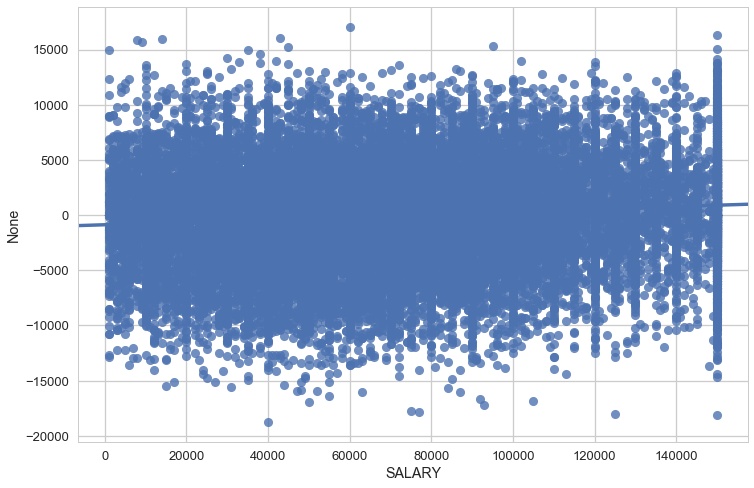

In [19]:
### GREG ADDED - DELETE LATER ###
print( np.mean( y_pred), np.mean( y_pred_base ))



fig, ax = plt.subplots( figsize = (12,8))
sns.regplot( y_test, y_pred_base - y_pred, ax = ax )

In [20]:
### GREG ADDED - DELETE LATER ###
n = y_pred.shape[0]
n_base = y_pred_base.shape[0] 

y_pred_mean = np.mean( y_pred )
y_pred_base_mean = np.mean( y_pred_base )

SSE = np.sum( ( y_pred - y_test) * ( y_pred - y_test ) )
SSE_base = np.sum( ( y_pred_base - y_test) * ( y_pred_base - y_test ) )

TSS = np.sum( ( y_pred - y_pred_mean ) * ( y_pred - y_pred_mean ) )
TSS_base = np.sum( ( y_pred_base - y_pred_base_mean ) * ( y_pred_base - y_pred_base_mean) )

print( y_pred_mean, y_pred_base_mean )
print( SSE, SSE_base )
print( TSS, TSS_base )
print( SSE / TSS, SSE_base / TSS_base)
print( np.sqrt( mean_squared_error( y_pred, y_test) ), np.sqrt( mean_squared_error( y_pred_base, y_test) ) )


77306.4558295 77343.78306298982
20748325103737.82 20109837838728.06
2.5613240316e+13 26077572827031.957
0.810062485174 0.7711545078260598
27091.2234203 26671.1277772


                            OLS Regression Results                            
Dep. Variable:                 SALARY   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     1958.
Date:                Wed, 02 May 2018   Prob (F-statistic):               0.00
Time:                        20:15:36   Log-Likelihood:            -1.5275e+05
No. Observations:               13146   AIC:                         3.056e+05
Df Residuals:                   13082   BIC:                         3.061e+05
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
GENDER           7040.5347    499.511     

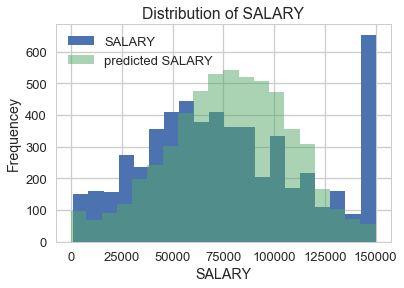

In [21]:
feature_p = pd.DataFrame(res3.pvalues, columns=['Pvalue'])
feature_select = feature_p[feature_p['Pvalue']<=0.001]
ls = []
ls = feature_select.index.tolist()

df_employed_no = df_employed_d[(df_employed_d['SALARY']>0)].sample(frac=0.2, random_state=41).reset_index()

X = df_employed_no[df_employed_no['YEAR']==2013][ls]
y = df_employed_no[df_employed_no['YEAR']==2013]['SALARY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=41)


mod = sm.OLS(y_train, X_train)
res4 = mod.fit()
print(res4.summary())

y_pred = res4.predict(X_test)
y_pred = np.clip(y_pred, 0, 150000)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))


plt.hist(y_test, bins=20, label='SALARY')
plt.hist(y_pred,  bins=20, alpha=0.5, label='predicted SALARY')
plt.title("Distribution of SALARY")
plt.legend()
plt.xlabel("SALARY")
plt.ylabel("Frequencey")
plt.show()

#infl = res4.get_influence()
#print(infl.)

#X_train[res4.outlier_test()['bonf(p)']!=1].index

In [22]:
#Outlier test 

df_employed_no = df_employed_d[(df_employed_d['SALARY']>0)].sample(frac=0.01, random_state=41).reset_index()

X = df_employed_no[df_employed_no['YEAR']==2013][ls]
y = df_employed_no[df_employed_no['YEAR']==2013]['SALARY']

print('Number of entries:', len(y))

#infl = res4.get_influence()
mod6 = sm.OLS(y, X)
res6 = mod6.fit()

test = res6.outlier_test() 
outliers = X[(test['unadj_p'] < 0.5)].index
X_new =X.drop(outliers, axis=0)
y_new =y.drop(outliers, axis=0)
print('Number of entries after filtering:', len(y_new))


Number of entries: 929


/anaconda/lib/python3.6/site-packages/numpy/linalg/linalg.py:1821: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Number of entries after filtering: 476


                            OLS Regression Results                            
Dep. Variable:                 SALARY   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     388.5
Date:                Wed, 02 May 2018   Prob (F-statistic):          2.47e-232
Time:                        20:15:49   Log-Likelihood:                -3488.8
No. Observations:                 333   AIC:                             7106.
Df Residuals:                     269   BIC:                             7349.
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
GENDER           5321.1131   1270.243     

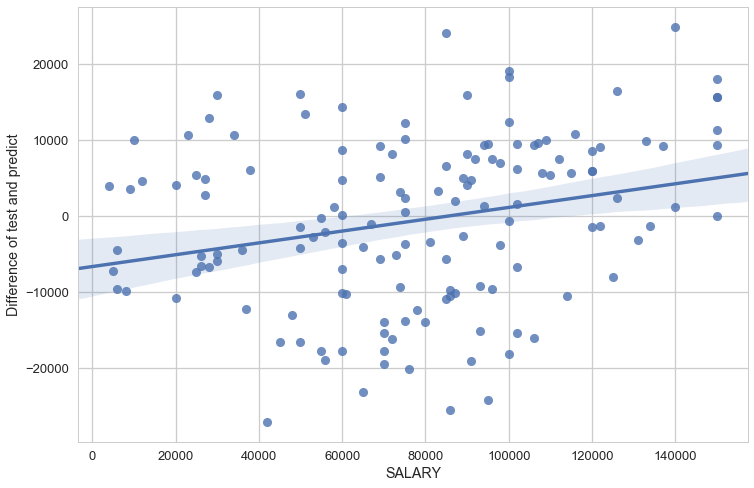

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size = 0.3, random_state=41)


#Regression fit without outliers
mod = sm.OLS(y_train, X_train)
res5 = mod.fit()
print(res5.summary())

y_pred = res5.predict(X_test)
y_pred = np.clip(y_pred, 0, 150000)
y_pred_train = res5.predict(X_train)

rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))

fig, ax = plt.subplots( figsize=( 12,8))
sns.regplot( y_test, y_test - y_pred)
plt.ylabel('Difference of test and predict')


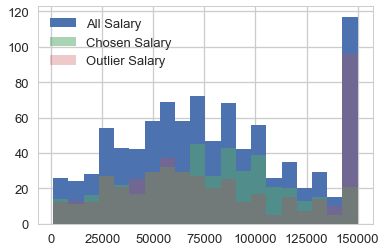

In [24]:
#distribution of all salaries and salaries in chosen and outlier groups
plt.hist(y, bins=20, label='All Salary')
plt.hist(y_new, bins=20, alpha=0.5, label='Chosen Salary')
plt.hist(y[outliers], bins=20, alpha=0.3, label='Outlier Salary')
plt.legend()

In [25]:

X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size = 0.3, random_state=41)

# Create the regressor: reg
reg = Ridge()

# Fit the model to the data
reg.fit(X_train,y_train)

# Compute predictions over the prediction space: y_pred
y_pred = reg.predict(X_test)

# Cap the predicted value at 150000 as in the original data set 
y_pred = np.clip(y_pred, 0, 150000)


# Print R^2 
print('training score:', reg.score(X_train, y_train))
print('testing score:', reg.score(X_test, y_test))

rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))

scores = cross_val_score(reg, X_train, y_train, cv=5)
print('cross validation scores:', scores)

training score: 0.94087891832
testing score: 0.903974105056
Root Mean Squared Error: 11191.006024640701
cross validation scores: [ 0.8907042   0.91002362  0.90063903  0.89754033  0.89568062]


In [26]:
X_l = X.loc[outliers,:]
y_l = y[outliers]
X_l['salary'] = y_l

print('outlier gender distribution:', X_l['GENDER'].value_counts())
print('regression gender distribution:', X_new['GENDER'].value_counts())
#X_l_s = X_l[X_l['salary']<=100000]
#y_l_small = X_l_s['salary']
#X_l_small = X_l_s.drop('salary', axis=1)


outlier gender distribution: 2    251
1    202
Name: GENDER, dtype: int64
regression gender distribution: 2    265
1    211
Name: GENDER, dtype: int64


In [27]:
X_new_s = X_new
X_new_s['salary'] = y_new
xl_mean = pd.DataFrame(X_l.mean())
xnew_mean = pd.DataFrame(X_new_s.mean())
xnew_mean.merge(xl_mean, right_index=True, left_index=True)


,0_x,0_y
GENDER,1.556723,1.554084
BTHUS,0.768908,0.781457
CTZUSIN,0.894958,0.916115
ACTRD,0.453782,0.426049
ACTRDT,0.575630,0.556291
NBAMED_547280.0,0.067227,0.046358
NBAMEMG_2.0,0.134454,0.174393
NBAMEMG_7.0,0.081933,0.083885
NDGMED_298895,0.025210,0.019868
NDGMED_699995,0.037815,0.015453


In [28]:
#Fit the "leftover" data some other way

# Cross validation fit result not good
from sklearn.ensemble import RandomForestRegressor
X_l = X.loc[outliers,:]
y_l = y[outliers]
X_train, X_test, y_train, y_test = train_test_split(X_l, y_l, test_size = 0.3, random_state=41)

# Create the regressor: reg
reg = RandomForestRegressor(n_estimators=10, max_features=10, max_depth=10)

# Fit the model to the data
reg.fit(X_train,y_train)

# Compute predictions over the prediction space: y_pred
y_pred = reg.predict(X_test)

# Cap the predicted value at 150000 as in the original data set 
y_pred = np.clip(y_pred, 0, 150000)


# Print R^2 
print('training score:', reg.score(X_train, y_train))
print('testing score:', reg.score(X_test, y_test))

rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))

scores = cross_val_score(reg, X_train, y_train, cv=5)
print('cross validation scores:', scores)


training score: 0.721149357235
testing score: 0.161853702161
Root Mean Squared Error: 44777.02766649568
cross validation scores: [ 0.2506294   0.11494541  0.15735227  0.2198245   0.1593799 ]


In [29]:
df_employed_no = df_employed_d[(df_employed_d['SALARY']>0)].sample(frac=0.01, random_state=41).reset_index()

X = df_employed_no[df_employed_no['YEAR']==2013][ls]
y = df_employed_no[df_employed_no['YEAR']==2013]['SALARY']




In [30]:
feature_p = pd.DataFrame(res3.pvalues, columns=['Pvalue'])
feature_select = feature_p[feature_p['Pvalue']<=0.001]
ls = []
ls = feature_select.index.tolist()

df_employed_no = df_employed_d[(df_employed_d['SALARY']>0)]

X = df_employed_no[df_employed_no['YEAR']==2013][ls]
y = df_employed_no[df_employed_no['YEAR']==2013]['SALARY']


#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=41)

# Create the regressor: reg
reg = LinearRegression()

# Fit the model to the data
reg.fit(X_train,y_train)

# Compute predictions over the prediction space: y_pred
y_pred = reg.predict(X_test)

# Cap the predicted value at 150000 as in the original data set 
y_pred = np.clip(y_pred, 0, 150000)

# Print R^2 
print(reg.score(X_train, y_train))
print(reg.score(X_test, y_test))

rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))

print(X.shape)

scores = cross_val_score(reg, X_train, y_train, cv=5)
print('cross validation scores:', scores)


0.557234568847
0.561828883641
Root Mean Squared Error: 26865.083936931154
(94233, 64)
cross validation scores: [ 0.56794262  0.55219375  0.55480617  0.54936561  0.55695781]


Above gives the result from the linear regresssion by statsmodel. We see the correlation is statistically significant (p-value from the F-statistic). The R^2 score is consistent with what is given by sklearn linear models. 

I tried to use the log of the target feature (salary), it gave a better result (0.57=>0.6) when taking a power of 6.

In [31]:
#cross validation result bad
df_employed_no = df_employed_d[(df_employed_d['SALARY']>0)]
df_sample = df_employed_no[df_employed_no['YEAR']==2013]
#.sample(frac=0.2, random_state=42)

X_s = df_sample.drop(['SALARY'], axis=1)
y_s = np.log(df_sample['SALARY'])**6

#train test split
X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size = 0.3, random_state=41)

reg = LinearRegression()

# fit to an order-2 polynomial data

reg.fit(X_train, y_train)

# Compute predictions over the prediction space: y_pred
y_pred = reg.predict(X_test)

# Print R^2 
print(reg.score(X_test, y_test))

rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))

scores = cross_val_score(reg, X_train, y_train, cv=5)
print('cross validation scores:', scores)

0.603876529305
Root Mean Squared Error: 391760.7756809568
cross validation scores: [ 0.60524054  0.59283415  0.59360091  0.5856108   0.592415  ]


In [32]:
#Use grid search for random forest regressor
# Import necessary modules
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
X = df_employed_no[df_employed_no['YEAR']==2013].drop(['SALARY'], axis=1)
y = df_employed_no[df_employed_no['YEAR']==2013]['SALARY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=41)

param_grid = {"n_estimators": [10, 30, 50],
              "max_features": [10, 30],
              "max_depth": [10, 100, 300]
              }

# Instantiate a logistic regression classifier: logreg
rfr = RandomForestRegressor()

# Instantiate the GridSearchCV object: logreg_cv
rfr_cv = GridSearchCV(rfr, param_grid, cv=5)

# Fit it to the data
rfr_cv.fit(X_train,y_train)

y_rfr_cv = rfr_cv.predict(X_test)

rmse_rfr_cv = np.sqrt(mean_squared_error(y_test,y_rfr_cv))

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(rfr_cv.best_params_)) 
print("Best score is {}".format(rfr_cv.best_score_))

# test data result
print("Score on the test data is: ", rfr_cv.score(X_test, y_test))

# Print RMSE
print("RBF Root Mean Squared Error: {}".format(rmse_rfr_cv))

Tuned Logistic Regression Parameters: {'max_depth': 100, 'max_features': 30, 'n_estimators': 50}
Best score is 0.5819658686604209
Score on the test data is:  0.596043922217
RBF Root Mean Squared Error: 25888.970404079384


0.597627903968
RBF Root Mean Squared Error: 25838.162980371704
cross validation scores: [ 0.58897944  0.58190369  0.58199351  0.57796855  0.58085192]


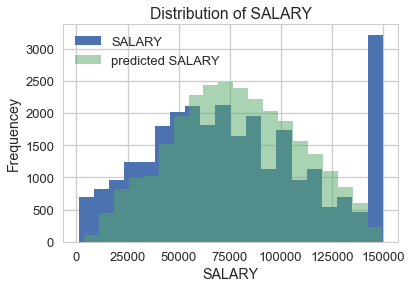

In [33]:
## Trying random forest regressor 
#df_sample = df_employed_no[df_employed_no['YEAR']==2013]
#.sample(frac=0.2, random_state=42)

#X_s = df_sample.drop(['SALARY'], axis=1)
#y_s = df_sample['SALARY']

#train test split
#X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size = 0.3, random_state=41)

#feature_p = pd.DataFrame(res3.pvalues, columns=['Pvalue'])
#feature_select = feature_p[feature_p['Pvalue']<=0.001]
#ls = []
#ls = feature_select.index.tolist()

df_employed_no = df_employed_d[(df_employed_d['SALARY']>0)]

X = df_employed_no[(df_employed_no['YEAR']==2013)].drop(['SALARY'],axis=1)
y = df_employed_no[(df_employed_no['YEAR']==2013)]['SALARY']


#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=41)

# Use the random forest regressor
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=50, max_features=76, max_depth=100)

#rfr.fit(X,y)
# Use feature selection
#model = SelectFromModel(rfr, prefit=True)
#X_new = model.transform(X)

#train test split
#X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.3, random_state=42)

y_rfr = rfr.fit(X_train, y_train).predict(X_test)

#y_rfr = np.clip(y_rfr, 0, 150000)

rmse_rfr = np.sqrt(mean_squared_error(y_test,y_rfr))

# Print R2
print(rfr.score(X_test, y_test))
#print(coefficient_of_determination(y_test, y_rfr))

# Print RMSE
print("RBF Root Mean Squared Error: {}".format(rmse_rfr))


scores = cross_val_score(rfr, X_train, y_train, cv=5)
print('cross validation scores:', scores)

plt.hist(y_test, bins=20, label='SALARY')
plt.hist(y_rfr,  bins=20, alpha=0.5, label='predicted SALARY')
plt.title("Distribution of SALARY")
plt.legend()
plt.xlabel("SALARY")
plt.ylabel("Frequencey")
plt.show()



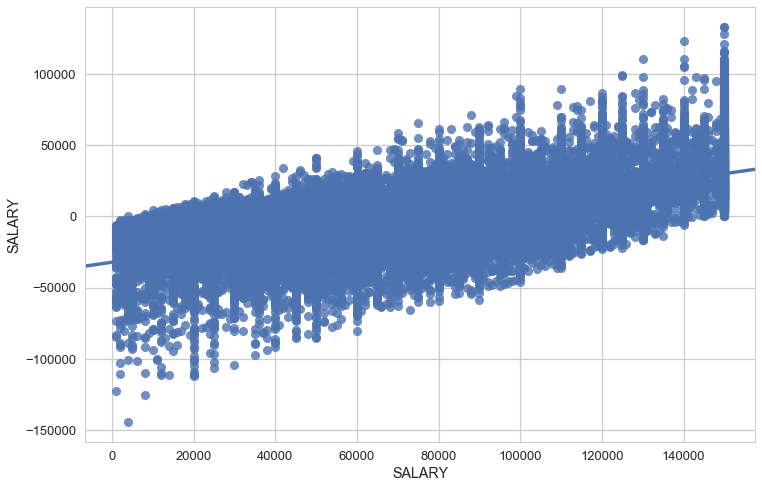

In [34]:
#### Plot the difference of salary and the predicted salary ###

fig, ax = plt.subplots( figsize=( 12,8))
sns.regplot( y_test, y_test - y_rfr)

Delete rows with 150000 salary and try the regression again. Linear regression:

0.544967460751
Root Mean Squared Error: 23092.40543115738


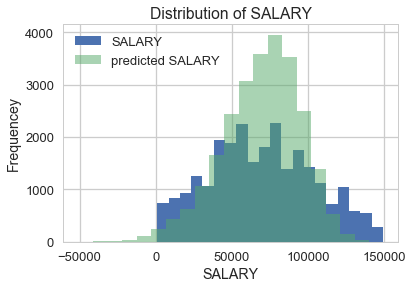

In [35]:
## Regression on data with less than 150000 salary


df_decap = df_sample[df_sample['SALARY']<150000]
X = df_decap.drop(['SALARY'], axis=1)
y = df_decap['SALARY']

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)


reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
#y_pred = np.clip(y_pred, 0, 150000)

# Print R^2 
print(reg.score(X_test, y_test))

rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))

#visualize the actual and predicted salaries 
plt.hist(y_test, bins=20, label='SALARY')
plt.hist(y_pred,  bins=20, alpha=0.5, label='predicted SALARY')
plt.title("Distribution of SALARY")
plt.legend()
plt.xlabel("SALARY")
plt.ylabel("Frequencey")
plt.show()


Random forest regressor with less 150000 salary entries:

Score on the test data is:  0.556683297951
Root Mean Squared Error: 22793.183853651917


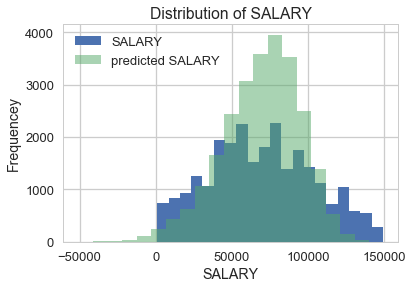

In [36]:
# Instantiate a random forest regressor
rfr = RandomForestRegressor(n_estimators=100, max_features=25, max_depth=100)

# Fit it to the data
rfr.fit(X_train,y_train)

y_rfr = rfr.predict(X_test)

rmse_rfr = np.sqrt(mean_squared_error(y_test,y_rfr))

# test data result
print("Score on the test data is: ", rfr.score(X_test, y_test))

# Print RMSE
print("Root Mean Squared Error: {}".format(rmse_rfr))


#visualize the actual and predicted salaries 
plt.hist(y_test, bins=20, label='SALARY')
plt.hist(y_pred,  bins=20, alpha=0.5, label='predicted SALARY')
plt.title("Distribution of SALARY")
plt.legend()
plt.xlabel("SALARY")
plt.ylabel("Frequencey")
plt.show()


#### The result does not seem better when neglecting the capped target rows!

Use feature selection and try the regression again.

shape of X:  (94233, 183)
shape of X_new:  (94233, 41)
0.206984250494
Root Mean Squared Error: 36207.13081887106


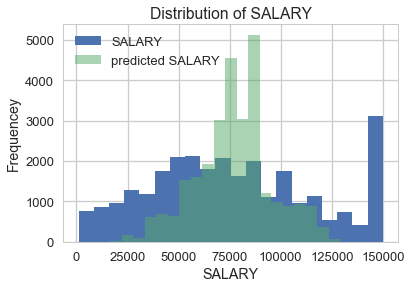

In [37]:
X = df_sample.drop(['SALARY'], axis=1)
y = df_sample['SALARY']

reg = LinearRegression()
reg.fit(X,y)

from sklearn.feature_selection import SelectFromModel
#Use feature selection
model = SelectFromModel(reg, prefit=True)
X_new = model.transform(X)

print("shape of X: ", X.shape)
print("shape of X_new: ", X_new.shape)
#train test split
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.3, random_state=42)

# Fit the model to the new data
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
y_pred = np.clip(y_pred, 0, 150000)


# Print R^2 
print(reg.score(X_test, y_test))

rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))

# your turn

plt.hist(y_test, bins=20, label='SALARY')
plt.hist(y_pred,  bins=20, alpha=0.5, label='predicted SALARY')
plt.title("Distribution of SALARY")
plt.legend()
plt.xlabel("SALARY")
plt.ylabel("Frequencey")
plt.show()


#### The score ($R^2$) did not improve with the data processing of feature selection （selectfrommodel). 

In [38]:
## Trying SVR 
from sklearn.svm import SVR

df_sample = df_employed_no.sample(frac=0.1, random_state=42)

X = df_sample.drop(['SALARY'], axis=1)
y = df_sample['SALARY']


#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)


svr_rbf = SVR(kernel='rbf', C=120000, gamma=0.005)
#svr_lin = SVR(kernel='linear', C=1e3)
#svr_poly = SVR(kernel='poly', C=1e3, degree=2)
y_rbf = svr_rbf.fit(X_train, y_train).predict(X_test)
#y_lin = svr_fit(X_train, y_train).predict(X_test)
#y_poly = svr_fit(X_train, y_train).predict(X_test)

rmse_rbf = np.sqrt(mean_squared_error(y_test,y_rbf))
#rmse_lin = np.sqrt(mean_squared_error(y_test,y_lin))
#rmse_poly = np.sqrt(mean_squared_error(y_test,y_poly))

# Print R^2 
print(svr_rbf.score(X_test, y_test))

# Print RMSE
print("RBF Root Mean Squared Error: {}".format(rmse_rbf))
#print("LIN Root Mean Squared Error: {}".format(rmse_lin))
#print("Poly Root Mean Squared Error: {}".format(rmse_poly))

0.548718111248
RBF Root Mean Squared Error: 26649.728727767124


In [39]:
# Trying to predict NOCPRMG or WAPRSM

In [40]:
#df_employed_clf = df_employed_no
df_employed_clf =[]
df_employed_clf = df_employed_l[df_employed_l['SALARY']>0]
df_employed_clf.columns

Index(['YEAR', 'SAMPLE', 'SURID', 'AGE', 'BIRYR', 'GENDER', 'MINRTY', 'RACETH',
       'BTHUS', 'CTZUSIN', 'NBAMED', 'NBAMEMG', 'DGRDG', 'HD03Y5', 'NDGMED',
       'NDGMEMG', 'HRSWKGR', 'WKSWKGR', 'OCEDRLP', 'NOCPR', 'NOCPRMG',
       'SALARY', 'JOBSATIS', 'EMSEC', 'EMSIZE', 'GOVSUP', 'WAPRSM', 'ACTCAP',
       'ACTDED', 'ACTMGT', 'ACTRD', 'ACTRDT', 'ACTRES', 'ACTTCH', 'WKTRNI',
       'WAPRI', 'WASEC', 'WASCSM'],
      dtype='object')

In [41]:
#classify genders from other features: Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


X = df_employed_clf.drop(['GENDER'], axis=1)
y = df_employed_clf['GENDER']

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

#initiate a instance for classifier
clf = RandomForestClassifier(n_estimators=100, max_features=25, max_depth=100)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Predict the labels of the test data: y_pred
y_pred = clf.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[27889 16783]
 [10843 61454]]
             precision    recall  f1-score   support

          1       0.72      0.62      0.67     44672
          2       0.79      0.85      0.82     72297

avg / total       0.76      0.76      0.76    116969



In [42]:
#predict gender for social science jobs (almost the same men and women in the field)

X = df_employed_clf[df_employed_clf['NOCPRMG']==4].drop(['GENDER'], axis=1)
y = df_employed_clf[df_employed_clf['NOCPRMG']==4]['GENDER']

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#initiate a instance for classifier
clf = RandomForestClassifier(n_estimators=30, max_features=25, max_depth=200)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Predict the labels of the test data: y_pred
y_pred = clf.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[3742 1278]
 [1632 2985]]
             precision    recall  f1-score   support

          1       0.70      0.75      0.72      5020
          2       0.70      0.65      0.67      4617

avg / total       0.70      0.70      0.70      9637



In [43]:
#classify the field of job from other columns 
#Use dummied data to model

df_employed_field = pd.get_dummies(df_employed_l, columns=['RACETH','NBAMED', 'NBAMEMG', 'NDGMED', 'EMSEC','EMSIZE', 'GOVSUP', 'NDGMEMG', 'OCEDRLP', 'WAPRSM', 'WAPRI', 'WKTRNI', 'WASEC', 'WASCSM', 'SAMPLE', 'HD03Y5', 'DGRDG', 'JOBSATIS','SURID','HRSWKGR','WKSWKGR'], drop_first=True)
df_employed_field_no = df_employed_field[df_employed_field['SALARY']!=0]
X = df_employed_field_no[df_employed_no['GENDER']==1].drop(['NOCPRMG','NOCPR'], axis=1)
y = df_employed_field_no[df_employed_no['GENDER']==1]['NOCPRMG']

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

#initiate a instance for classifier
clf = RandomForestClassifier(n_estimators=100, max_features=25, max_depth=100)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Predict the labels of the test data: y_pred
y_pred = clf.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 3096    84    37    62   187   257   626]
 [   55  3052   185    93    64   390   303]
 [   30   228  1355    18    74    94   170]
 [   62    69    10  3960    10   158   769]
 [  212    51    83     6  2215    56   219]
 [  490   587   112   128   217  8184  1545]
 [  350   295   100   690   281  1196 12144]]
             precision    recall  f1-score   support

        1.0       0.72      0.71      0.72      4349
        2.0       0.70      0.74      0.72      4142
        3.0       0.72      0.69      0.70      1969
        4.0       0.80      0.79      0.79      5038
        5.0       0.73      0.78      0.75      2842
        6.0       0.79      0.73      0.76     11263
        7.0       0.77      0.81      0.79     15056

avg / total       0.76      0.76      0.76     44659



In [44]:
#predict the field of job from other columns 
#Use original data to feed into random forest classifier

X = df_employed_clf[df_employed_clf['GENDER']==1].drop(['NOCPRMG','NOCPR'], axis=1)
y = df_employed_clf[df_employed_clf['GENDER']==1]['NOCPRMG']

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

#initiate a instance for classifier
clf = RandomForestClassifier(n_estimators=100, max_features=25, max_depth=100)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Predict the labels of the test data: y_pred
y_pred = clf.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 3103    80    37    62   199   251   617]
 [   54  3054   176    94    63   405   296]
 [   24   227  1353    17    71   113   164]
 [   53    77     8  3968    13   145   774]
 [  200    57    82     4  2174    71   254]
 [  492   562    98   137   202  8189  1583]
 [  372   290   103   712   271  1180 12128]]
             precision    recall  f1-score   support

        1.0       0.72      0.71      0.72      4349
        2.0       0.70      0.74      0.72      4142
        3.0       0.73      0.69      0.71      1969
        4.0       0.79      0.79      0.79      5038
        5.0       0.73      0.76      0.75      2842
        6.0       0.79      0.73      0.76     11263
        7.0       0.77      0.81      0.79     15056

avg / total       0.76      0.76      0.76     44659



#### Dummied and original data gave the same result with the random forest classifier

In [45]:
# Predict women prime job activity from other not related columns 

X = df_employed_clf[df_employed_clf['GENDER']==1].drop(['SALARY', 'WAPRSM', 'WAPRI', 'WASEC','WASCSM'], axis=1)
y = df_employed_clf[df_employed_clf['GENDER']==1]['WAPRSM'].astype('category')

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

#initiate a instance for classifier
clf = RandomForestClassifier(n_estimators=50, criterion='gini', max_depth=100)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Predict the labels of the test data: y_pred
y_pred = clf.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[7771  544  770  251  256]
 [ 302 7039  193    8  259]
 [1046  444 9424  266  936]
 [ 235   26  210 1838   65]
 [ 762  347 1928   85 9654]]
             precision    recall  f1-score   support

        1.0       0.77      0.81      0.79      9592
        2.0       0.84      0.90      0.87      7801
        3.0       0.75      0.78      0.76     12116
        4.0       0.75      0.77      0.76      2374
        5.0       0.86      0.76      0.81     12776

avg / total       0.80      0.80      0.80     44659



### Unsupervised learning 

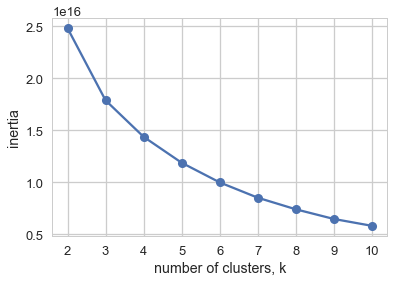

In [46]:
## Unsupervised learning model K means to find clusters.
## find number of clusters first

#X = df_employed_clf[df_employed_clf['NOCPRMG']==5].drop(['GENDER'], axis=1)
X = df_employed_clf.drop(['SALARY'], axis=1)

from sklearn.cluster import KMeans

#choose number of clusters by inertia

inertia = []
ks=range(2,11)

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(X)
     # Append the inertia to the list of inertias
    inertia.append(model.inertia_)
    
plt.plot(ks, inertia, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

#elbow point k=3

Use the number of clusters found above to cluster with KMeans. (original columns)

mean salary of the clusters: cluster
0    78733.069943
1    77716.730288
Name: salary, dtype: float64


/anaconda/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/anaconda/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp


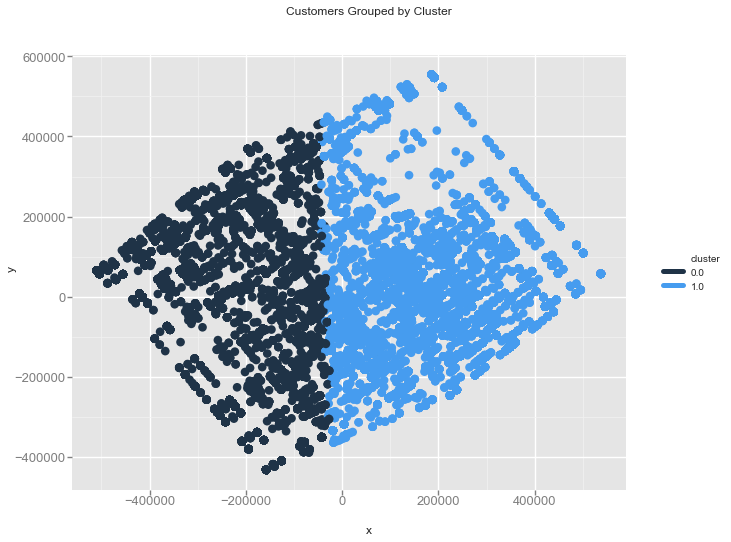

<ggplot: (306186644)>

In [47]:
#Use original columns to find clusters

model = KMeans(n_clusters=2)
X_sample_o = df_employed_clf.sample(frac=0.1, random_state=41)
X_sample = X_sample_o.drop(['SALARY'], axis=1)
clster = model.fit_predict(X_sample)

#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(X_sample)


X_sample['x'] = pca.fit_transform(X_sample)[:,0]
X_sample['y'] = pca.fit_transform(X_sample)[:,1]
X_sample['cluster'] = clster
X_sample['salary'] = X_sample_o['SALARY']
print('mean salary of the clusters:', X_sample.groupby('cluster').salary.mean())
                     
from ggplot import *

ggplot(X_sample, aes(x='x', y='y', color='cluster')) + \
    geom_point(size=75) + \
    ggtitle("Customers Grouped by Cluster")
    
    


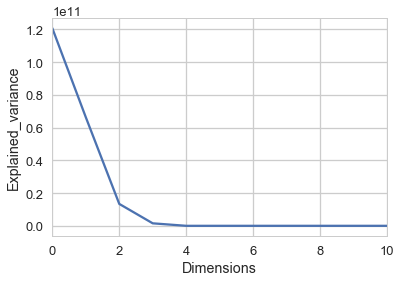

In [48]:
#your turn

# Initialize a new PCA model with a default number of components.
pca = sklearn.decomposition.PCA()
pca.fit(X_sample)

#plot explained variance
plt.plot(pca.explained_variance_)
plt.xlim([0,10])
plt.xlabel('Dimensions')
plt.ylabel('Explained_variance')



In [49]:
## Look at the difference of clusters: seems like the majors and fields are different
X_sample.groupby('cluster').mean().transpose()

cluster,0,1
YEAR,2008.208284,2008.316221
SAMPLE,810.092845,813.973191
SURID,1.536762,1.183055
AGE,44.891598,45.203063
BIRYR,1961.326934,1961.113817
GENDER,1.639360,1.603308
MINRTY,0.156676,0.197578
RACETH,1.974258,2.057918
BTHUS,0.734305,0.778114
CTZUSIN,0.888820,0.934141


Use the number of clusters found above to cluster with KMeans. (dummied column) We notice a different results from clustered with original columns.

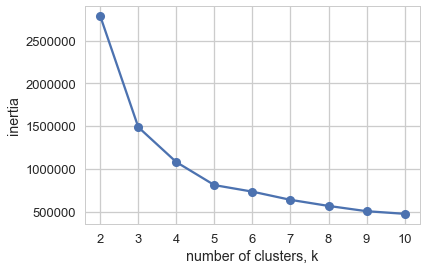

In [50]:
#Use dummied columns to find clusters, delete the salary, age, year and birth year factor and find clusters. 
#Find K first


X_sample_o = df_employed_no[df_employed_no['YEAR']==2013].sample(frac=0.3, random_state=41)
X_sample = X_sample_o.drop(['SALARY'], axis=1)

from sklearn.cluster import KMeans

#choose number of clusters by inertia

inertia = []
ks=range(2,11)

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(X_sample)
     # Append the inertia to the list of inertias
    inertia.append(model.inertia_)
    
plt.plot(ks, inertia, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()



In [51]:
#Use dummied columns to find clusters

model = KMeans(n_clusters=4)
X_sample_o = df_employed_no[df_employed_no['YEAR']==2013].sample(frac=0.3, random_state=41)
X_sample = X_sample_o.drop(['SALARY'], axis=1)
clster = model.fit_predict(X_sample)

#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(X_sample)


X_sample['x'] = pca.fit_transform(X_sample)[:,0]
X_sample['y'] = pca.fit_transform(X_sample)[:,1]
X_sample['cluster'] = clster
X_sample['salary'] = X_sample_o['SALARY']

print('mean salary of the clusters:', X_sample.groupby('cluster').salary.mean())
                
## Look at the difference of clusters: seems like the age is the major differences
print(X_sample.groupby('cluster').mean().transpose())

print(X_sample.groupby('cluster')['SAMPLE_1001'].mean())


#from ggplot import *

#ggplot(X_sample, aes(x='x', y='y', color='cluster')) + \
#    geom_point(size=75) + \
#    ggtitle("Customers Grouped by Cluster")
    

mean salary of the clusters: cluster
0    92224.319224
1    58223.930251
2    84606.302809
3    82395.177927
Name: salary, dtype: float64
cluster                     0             1             2             3
YEAR              2013.000000   2013.000000   2013.000000   2013.000000
AGE                 51.906983     29.096363     64.116693     39.288551
BIRYR             1959.270693   1982.452679   1946.595113   1971.470474
GENDER               1.607172      1.485832      1.694679      1.560083
MINRTY               0.180911      0.263049      0.131309      0.226405
BTHUS                0.755594      0.777217      0.834665      0.679990
CTZUSIN              0.955244      0.870483      0.986070      0.847731
ACTCAP               0.107441      0.146036      0.061201      0.114879
ACTDED               0.208816      0.251119      0.164649      0.219701
ACTMGT               0.551901      0.459906      0.505595      0.510186
ACTRD                0.423699      0.480326      0.380909      0.48091

Change the salary column from numeric to catagorical. Define the discrete steps.

In [52]:
def salary_bracket(ls):
    new_s = np.empty(len(ls))
    for i,s in enumerate(ls):
        if s<60000:
            new_s[i] = 1
        else:
            new_s[i] = 2
    return new_s

new_salary = salary_bracket(df_employed_clf[df_employed_clf['YEAR']==2013]['SALARY'])


In [53]:
df_employed_nod = []
df_employed_nod = df_employed_clf[df_employed_clf['YEAR']==2013].assign(salary_d=pd.Series(new_salary).values)
df_employed_nod.salary_d = df_employed_nod.salary_d.astype('category')
df_employed_nod=df_employed_nod.drop(['SALARY'], axis=1)

In [54]:
X = df_employed_nod[(df_employed_nod['GENDER']==1)].drop(['salary_d'], axis=1)
y = df_employed_nod[(df_employed_nod['GENDER']==1)]['salary_d']

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#initiate a instance for classifier
#clf = LogisticRegression()
clf = RandomForestClassifier(n_estimators=50, max_depth=100)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Predict the labels of the test data: y_pred
y_pred = clf.predict(X_test)

from sklearn.model_selection import cross_val_score
print(cross_val_score(clf, X_train, y_train, cv=5))

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[ 0.7885439   0.78890079  0.79710921  0.79568166  0.79657388]
[[4572 1153]
 [1259 5025]]
             precision    recall  f1-score   support

        1.0       0.78      0.80      0.79      5725
        2.0       0.81      0.80      0.81      6284

avg / total       0.80      0.80      0.80     12009



In [55]:
y.value_counts()

2.0    20769
1.0    19260
Name: salary_d, dtype: int64